In [4]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from scipy import signal

In [3]:
fname0 = 'cv/cd1.jpg'
img1 = cv2.imread(fname0)
fname1 = 'cv/cd2.jpg'
img2 = cv2.imread(fname1)
fname2 = 'cv/cd3.jpg'
img3 = cv2.imread(fname2)

img10 = cv2.imread('cv/c1.jpg')
img10 = cv2.resize(img10, (160, 128))
img20 = cv2.imread('cv/c2.jpg')
img20 = cv2.resize(img20, (160, 128))
img30 = cv2.imread('cv/c3.jpg')
img30 = cv2.resize(img30, (160, 128))


In [10]:
img = cv2.imread('cv/c1.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (5,5),None)

In [13]:
corners.shape

(25, 1, 2)

In [1]:
def get_camera_matrix(images):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((5*5,3), np.float32)
    objp[:,:2] = np.mgrid[0:5,0:5].T.reshape(-1,2)
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (5,5),None)
        if ret == True:
            objpoints.append(objp)

            corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
            imgpoints.append(corners2)
        
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    #print(rvecs, tvecs)
    return mtx, dist,imgpoints
    

In [3]:
images = glob.glob('cv/*.jpg')
mtx, dist, imgpoints = get_camera_matrix(images)

In [4]:
def trans_matrix(r,t):
    # T (ki to t), rotate and transport matrix
    (a,b,c) = (r[0][0], r[1][0], r[2][0])
    (x,y,z) = (t[0][0],t[1][0],t[2][0])
    Rz = np.matrix([[1,0,0],
          [0, np.cos(a), -np.sin(a)],
         [0, np.sin(a), np.cos(a)]])
    Ry = np.matrix([[np.cos(b), 0 , np.sin(b)],
          [0 , 1, 0],
          [-np.sin(b), 0 , np.cos(b)]])
    Rx = np.matrix([[np.cos(c), -np.sin(c), 0],
         [np.sin(c), np.cos(c), 0],
         [0,0,1]])
    R = np.dot(Rz,np.dot(Ry,Rx))
    T = np.concatenate((R, np.matrix([[x],[y],[z]])), axis=1)
    
    return T

In [5]:
def transpose_matrix(fname, mtx, dist):  
    objp = np.zeros((5*5,3), np.float32)
    objp[:,:2] = np.mgrid[0:5,0:5].T.reshape(-1,2)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (5,5),None)
    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        # Find the rotation and translation vectors.
        _, rvecs, tvecs, inliers = cv2.solvePnPRansac(objp, corners2, mtx, dist)
    else:
        return False
    T = trans_matrix(rvecs, tvecs)
    
    return T

In [6]:
fname = 'cv/c3.jpg'
T3 = transpose_matrix(fname,mtx, dist)
fname = 'cv/c2.jpg'
T2 = transpose_matrix(fname,mtx, dist)
fname = 'cv/c1.jpg'
T1 = transpose_matrix(fname,mtx, dist)

In [26]:
imgt

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [123,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

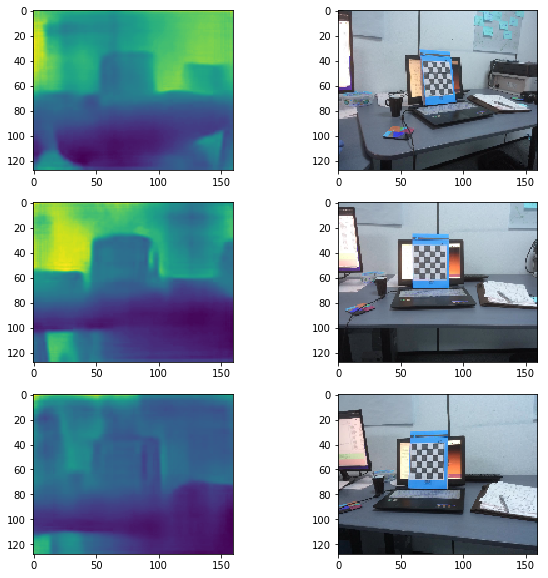

In [22]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.figure(1)
plt.subplot(321)
plt.imshow(img1[:,:,1])

plt.subplot(322)
plt.imshow(img10)

plt.subplot(323)
plt.imshow(img2[:,:,1])

plt.subplot(324)
plt.imshow(img20)

plt.subplot(325)
plt.imshow(img3[:,:,1])

plt.subplot(326)
plt.imshow(img30)
plt.show()

In [95]:
def vert(img,D, T,K, inv = True):
    l = img.shape[0]
    h = img.shape[1]
    t = 0
    temp = np.zeros((l*h, 6))
    T = np.concatenate((T, np.array([[0,0,0,1]])), axis=0)
    if inv:
        T = np.linalg.inv(T)
    K = np.eye(3)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if 10 < D[i,j]< 200:
                u = np.array([i,j, D[i,j], 1])
                aa = np.dot(T, u)
                x = np.zeros(3)
                x[0:3] = aa[0:3]/aa[3]
                x = np.dot(K, x)
            
                temp[t,0] = x[0]
                temp[t,1] = x[1]
                temp[t,2] = x[2]
                temp[t,3:6] = img[i,j]
                t = t+1
    return temp

In [132]:
res1 = vert(img10, img1[:,:,1], T1, mtx)
res2 = vert(img20, img2[:,:,1], T2, mtx)
res3 = vert(img30, img3[:,:,1], T3, mtx)
res = np.concatenate((res1,res2,res3), axis=0)
res.shape

(61440, 6)

## try to delete some points

In [15]:
import collections

In [53]:
records_array = np.array([1, 2, 3, 1, 1, 3, 4, 4, 3, 2])
idx_sort = np.argsort(records_array)
sorted_records_array = records_array[idx_sort]
vals, idx_start, count = np.unique(sorted_records_array, return_counts=True,
                                return_index=True)

# sets of indices
res = np.split(idx_sort, idx_start[1:])
#filter them with respect to their size, keeping only items occurring more than once

vals = vals[count > 1]
res = filter(lambda x: x.size > 1, res)

In [102]:
l=((np.size(x))*95)/100
idx_sort[1: l]
cc[:,l]

In [34]:
import sparse

In [144]:
def get_spm(res):
    n = 2000
    ndims = 3
    coords = 1000 + np.floor(res[:,0:3].T)
    datar = res[:,3].T
    datag = res[:,4].T
    datab = res[:,5].T

    r = sparse.COO(coords, datar, shape=((n,) * ndims))
    g = sparse.COO(coords, datag, shape=((n,) * ndims))
    b = sparse.COO(coords, datab, shape=((n,) * ndims))
    return coords,r,g,b

In [142]:
def combine(res1, res2):
    c1, r1, g1, b1 = get_spm(res1)
    c2, r2, g2, b2 = get_spm(res2)
    for i in range(c1.shape[1]):
        
    
    r = (r1+r2)/2
    g = (g1+g2)/2
    b = (b1+b2)/2
    bbb = r.coords
    
    
    return bbb,r, g, b

In [145]:
def get_res(c, r, g, b):
    l = c.shape[1]
    temp = np.zeros((l, 6))

    for i in range(l):
        temp[i,0] = c[0,i] - 1000
        temp[i,1] = c[1,i] -1000
        temp[i,2] = c[2,i]-1000
        
        temp[i,3] = r[c[0,i],c[1,i],c[2,i]]
        temp[i,4] = g[c[0,i],c[1,i],c[2,i]]
        temp[i,5] = b[c[0,i],c[1,i],c[2,i]]
               
    return temp

In [152]:
cc.shape[1]

57460

In [146]:
cc, rr, gg, bb= combine(res1,res2)
res00 = get_res(cc, rr, gg, bb)

In [148]:
cc, rr, gg, bb= combine(res00,res3)
res00 = get_res(cc, rr, gg, bb)

In [149]:

write_ply('out2.ply', res00)
print('%s saved' % 'out1.ply')

out1.ply saved


## write the 3d model

In [94]:
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar blue
property uchar green
end_header
'''
def write_ply(fn,verts ):
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d')

In [113]:

write_ply('out2.ply', res00)
print('%s saved' % 'out1.ply')


out1.ply saved


## ORB

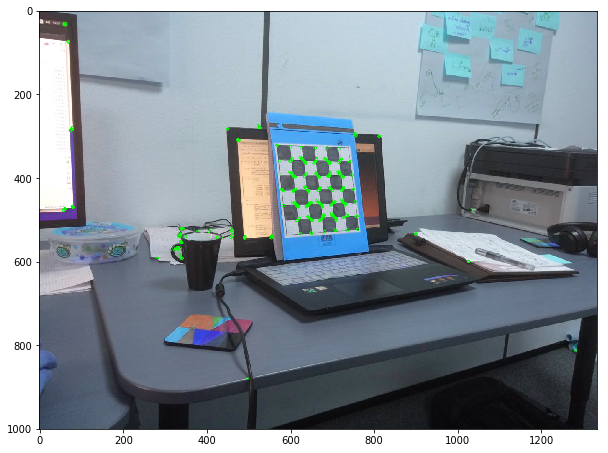

(<matplotlib.image.AxesImage at 0x21c50db59e8>, None)

In [157]:

img = cv2.imread('cv/c1.jpg')
# Initiate ORB detector
orb = cv2.ORB_create()
# find the keypoints with ORB
kp = orb.detect(img,None)
# compute the descriptors with ORB
kp, des = orb.compute(img, kp)
# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()

In [6]:
img11

array([[ 76,  77,  80, ..., 147, 147, 148],
       [ 61,  62,  64, ..., 147, 147, 148],
       [ 62,  62,  61, ..., 147, 147, 148],
       ...,
       [ 61,  60,  60, ...,  44,  41,  38],
       [ 62,  61,  59, ...,  44,  41,  38],
       [ 61,  60,  58, ...,  47,  46,  46]], dtype=uint8)

# get transport matrix from SURF

In [6]:
img10 = cv2.imread('cv/c1.jpg')
img10 = cv2.resize(img10, (160*8, 128*8))
img11 = img10[:,:,0]
img20 = cv2.imread('cv/c2.jpg')
img20 = cv2.resize(img20, (160*8, 128*8))
img21 = img20[:,:,0]
surf = cv2.xfeatures2d.SURF_create()


In [7]:
img11

array([[ 76,  77,  80, ..., 147, 147, 148],
       [ 61,  62,  64, ..., 147, 147, 148],
       [ 62,  62,  61, ..., 147, 147, 148],
       ...,
       [ 61,  60,  60, ...,  44,  41,  38],
       [ 62,  61,  59, ...,  44,  41,  38],
       [ 61,  60,  58, ...,  47,  46,  46]], dtype=uint8)

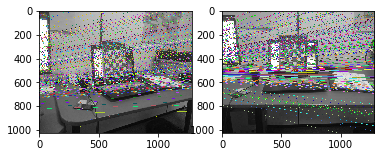

In [2]:
img10 = cv2.imread('cv/c1.jpg')
img10 = cv2.resize(img10, (160*8, 128*8))
img11 = img10[:,:,0]
img20 = cv2.imread('cv/c2.jpg')
img20 = cv2.resize(img20, (160*8, 128*8))
img21 = img20[:,:,0]
surf = cv2.xfeatures2d.SURF_create()



# find the keypoints and descriptors with SIFT
kp1, des1 = surf.detectAndCompute(img11,None)
kp2, des2 = surf.detectAndCompute(img21,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]


def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2


# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img11,img21,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img21,img11,lines2,pts2,pts1)

plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

In [10]:
pts1.shape

(342, 2)

## for 3D

In [7]:
def verttt(pts,D):
    res = np.zeros((1,len(pts) ,3),dtype = np.int8)
    for i in range(len(pts)):
        res[0][i][0] = int(pts[i][1]/8)
        res[0][i][1] = int(pts[i][0]/8)
        res[0][i][2] = D[res[0][i][0],res[0][i][1]]
    
    return res

In [10]:
pts11 = verttt(pts1,img1[:,:,1] )
pts21 = verttt(pts2,img2[:,:,1] )

In [11]:
retval, M, inliers = cv2.estimateAffine3D(pts11, pts21)
M

array([[ 9.79979980e-01,  2.52252252e-01, -2.93293293e-01,
         5.95795796e+00],
       [ 4.30430430e-02,  6.57657658e-01,  5.80580581e-01,
        -4.26096096e+01],
       [ 4.01401401e-01, -6.57657658e-01,  5.30530531e-01,
         6.29429429e+01]])

In [106]:
img10 = cv2.imread('cv/c1.jpg')
img10 = cv2.resize(img10, (160, 128))
img20 = cv2.imread('cv/c2.jpg')
img20 = cv2.resize(img20, (160, 128))

T_eye = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
res1 = vert(img10, img1[:,:,1], M, mtx,inv = False)
res2 = vert(img20, img2[:,:,1], T_eye, mtx)
res = np.concatenate((res1,res2), axis=0)
res.shape

(40960, 6)

In [238]:
pts1

array([[ 500,  528],
       [ 483,  543],
       [  69,  472],
       ...,
       [1163,  928],
       [ 767,  313],
       [ 757,  978]])

In [210]:
pts2[0:4].dtype 

dtype('int32')

In [203]:
p = np.float32([[0,0],[720,0],[1280,0],[720,720]])
p

array([[   0.,    0.],
       [ 720.,    0.],
       [1280.,    0.],
       [ 720.,  720.]], dtype=float32)

## 2D

In [69]:
img2 = cv2.imread('cv/cd2.jpg')
img2.shape

(128, 160, 3)

In [5]:
img = cv2.imread('cv/cd1.jpg')
img = cv2.resize(img,(1334,1000))
img2 = cv2.imread('cv/cd2.jpg')
img2 = cv2.resize(img2,(1334,1000))

src_pts = np.float32(pts1).reshape(-1,1,2)
dst_pts = np.float32(pts2).reshape(-1,1,2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
dst = cv2.warpPerspective(img,M,(1334,1000))


NameError: name 'pts1' is not defined

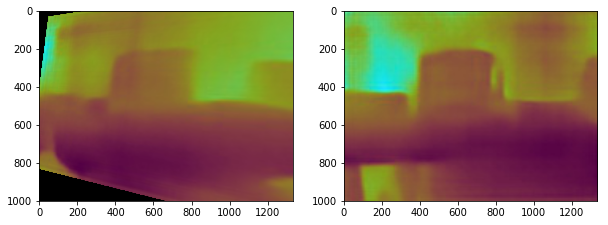

In [65]:
#plt.rcParams['figure.figsize'] = [10, 10]
plt.figure(1)
plt.subplot(121)
plt.imshow(dst)

plt.subplot(122)
plt.imshow(img2)

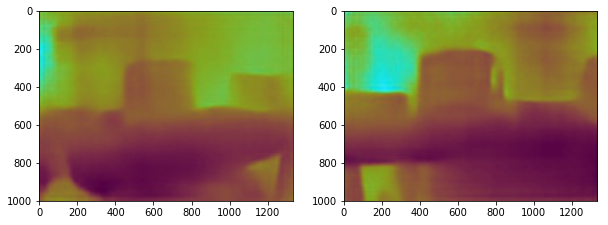

In [67]:
plt.figure(1)
plt.subplot(121)
plt.imshow(img)

plt.subplot(122)
plt.imshow(img2)

In [179]:

imgpts, jac = cv2.projectPoints(pts1.reshape(-1,3), rvecs, tvecs, mtx, dist)

error: C:\projects\opencv-python\opencv\modules\calib3d\src\solvepnp.cpp:253: error: (-215) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, 5), ipoints.checkVector(2, 6)) in function cv::solvePnPRansac


In [68]:
np.eye(4,3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])

# Uncertainty map

In [2]:
def pi_fcn(x):
    u = np.zeros((2,1), dtype = np.int8)

    u[0] = int(x[0])
    u[1] = int(x[1])
    return u

In [3]:
def uncertainty_fcn(K,T,x,D1,D2):
    t_x = np.zeros((4,1))
    t_x[0] = x[0]
    t_x[1] = x[1]
    t_x[2] = D1[x[0],x[1]]
    t_x[3] = 1
    l = D1.shape[0]
    h = D1.shape[1]
    
    
    temp = np.dot(T,t_x)
    temp = np.dot(K,temp)
    #print(temp[2])

    temp = pi_fcn(temp)
    
    #print( temp[0],temp[1],l,h)
    if 0<=temp[0]<l and 0<=temp[1]<h:
        depth = D2[temp[0],temp[1]]
    else:
        depth = t_x[2]
    
    return np.square((t_x[2]- depth)), temp

In [1]:
def uncertainty_matrix(K,T,D1,D2):
    l = D1.shape[0]
    h = D1.shape[1]
    res = np.zeros((l,h))
    restt = np.zeros((l,h))
    for i in range(l):
        for j in range(h):
            x = np.array((i,j))
            temp, tt = uncertainty_fcn(K,T,x,D1,D2)
            if temp > 0:
                res[i,j] = temp
            if 0<tt[0]<l and 0<tt[1]<h:
                restt[tt[0],tt[1]] = D2[i,j]
    return res

In [114]:
K = np.eye(3)
T = M
fname0 = 'cv/cd1.jpg'
img1 = cv2.imread(fname0)
fname1 = 'cv/cd2.jpg'
img2 = cv2.imread(fname1)

ttt = uncertainty_matrix(K,T,img1[:,:,1],img2[:,:,1])

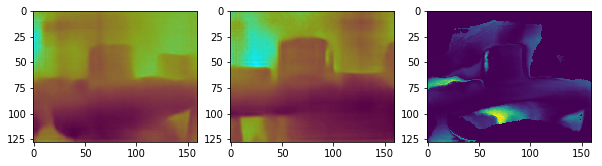

In [13]:
plt.rcParams['figure.figsize'] = [10, 10]

plt.figure(1)
plt.subplot(131)
plt.imshow(img1)

plt.subplot(132)
plt.imshow(img2)

plt.subplot(133)
plt.imshow(ttt)

supprimer les point n'est pas sur

In [90]:
def supp(img, U):
    l = U.shape[0]
    h = U.shape[1]
    for i in range(l):
        for j in range(h):
            if U[i,j] > 200:
                img[i,j] = 0
    return img

In [111]:
imgpp = cv2.Laplacian(img1[:,:,1], cv2.CV_8U)
imgpp[imgpp<200] = 0
ttt[imgpp>200] = 0

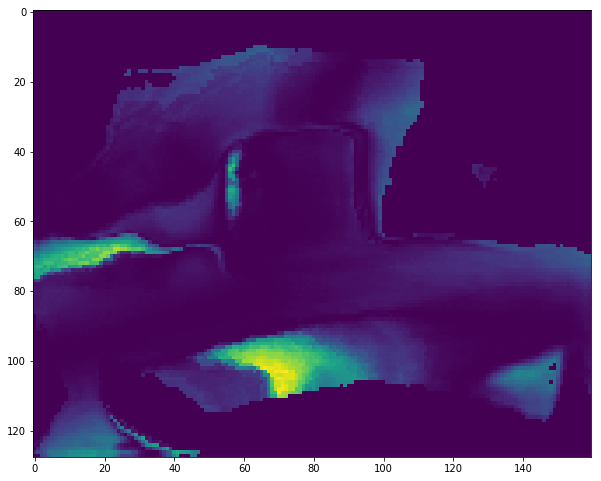

In [115]:
plt.imshow(ttt)

In [91]:
tttttt = img1[:,:,1]

In [92]:
imgt = supp(tttttt, ttt)

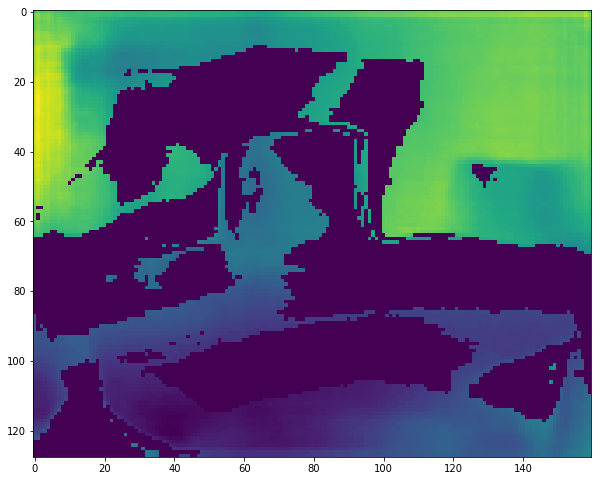

In [122]:
plt.imshow(imgt)

In [129]:
img10 = cv2.imread('cv/c1.jpg')
img10 = cv2.resize(img10, (160, 128))
img20 = cv2.imread('cv/c2.jpg')
img20 = cv2.resize(img20, (160, 128))
mtx = np.eye(3)
T_eye = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
res1 = vert(img10, imgt, M, mtx,inv = False)
res2 = vert(img20, img2[:,:,1], T_eye, mtx,inv = False)
res = np.concatenate((res1,res2), axis=0)

In [131]:

write_ply('out2.ply', res1)
print('%s saved' % 'out1.ply')

out1.ply saved


## propagation

In [34]:
def prog_fcn(K,T,x,Di,Dj,U):
    t_x = np.zeros((4,1))
    t_x[0] = x[0]
    t_x[1] = x[1]
    t_x[2] = Di[x[0],x[1]]
    t_x[3] = 1
    l = Di.shape[0]
    h = Di.shape[1]
    
    
    temp = np.dot(T,t_x)
    temp = np.dot(K,temp)
    temp = pi_fcn(temp)
    #print( temp[0],temp[1],l,h)
    if 0<=temp[0]<l and 0<=temp[1]<h:
        depth = Dj[temp[0],temp[1]]
        #print('hah')
    else :
        depth = t_x[2] 

    uu = U[temp[0], temp[1]]
    pp = 1
    #print(uu*(depth/t_x[2]))
    
    return temp[0], temp[1], uu*(depth/t_x[2]) + pp

In [35]:
def prog_matrix(K,T,Di,Dj,U):
    l = Di.shape[0]
    h = Di.shape[1]
    res = np.zeros((l,h))
    for i in range(l):
        for j in range(h):
            x = np.array((i,j))
            a, b, temp = prog_fcn(K,T,x,Di,Dj,U)
            if 0<=a<l and 0<=b<h:
                res[a,b] = temp
    return res

In [36]:
K = np.eye(3)
T = M
fname0 = 'cv/cd1.jpg'
img1 = cv2.imread(fname0)
fname1 = 'cv/cd2.jpg'
img2 = cv2.imread(fname1)
fname2 = 'cv/cd3.jpg'
img3 = cv2.imread(fname2)

t1 = np.zeros((160,128))+1
ttt = prog_matrix(K,T,img1[:,:,1],img2[:,:,1],t1)

E:\program\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


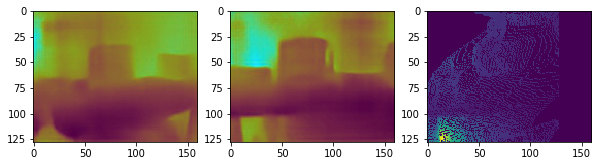

In [37]:
plt.rcParams['figure.figsize'] = [10, 10]

plt.figure(1)
plt.subplot(131)
plt.imshow(img1)

plt.subplot(132)
plt.imshow(img2)

plt.subplot(133)
plt.imshow(ttt)

## refinement

In [38]:
def refine_fcn(K,T,x,Di,Dj,U_i,U_jj):
    t_x = np.zeros((4,1))
    t_x[0] = x[0]
    t_x[1] = x[1]
    t_x[2] = Di[x[0],x[1]]
    t_x[3] = 1
    l = Di.shape[0]
    h = Di.shape[1]
    
    #x : u,  temp: v
    #
    temp = np.dot(T,t_x)
    temp = np.dot(K,temp)
    temp = pi_fcn(temp)
    #print( temp[0],temp[1],l,h)
    if 0<=temp[0]<l and 0<=temp[1]<h:
        depth = Dj[temp[0],temp[1]]
        Drefine = U_jj[temp[0],temp[1]]*t_x[2] + U_i[x[0],x[1]]*Dj[temp[0],temp[1]]
        Drefine = Drefine/(U_i[x[0],x[1]]+U_jj[temp[0],temp[1]])
        
        Urefine = U_jj[temp[0],temp[1]]*U_i[x[0],x[1]]/(U_jj[temp[0],temp[1]]+U_i[x[0],x[1]])
    else :
        Drefine = Di[x[0],x[1]]
        Urefine = 0
    
    
    return Drefine, Urefine

In [39]:
def refine_matrix(K,T,Di,Dj,U_j):
    l = Di.shape[0]
    h = Di.shape[1]
    res_d = np.zeros((l,h))
    res_u = np.zeros((l,h))
    U_i = uncertainty_matrix(K,T,Di,Dj)
    U_jj = prog_matrix(K,T,Di,Dj,U_j)
    for i in range(l):
        for j in range(h):
            x = np.array((i,j))
            res_d[i,j], res_u[i,j] = refine_fcn(K,T,x,Di,Dj,U_i,U_jj)
    return res_d, res_u

In [40]:
K = np.eye(3)
T = M
fname0 = 'cv/cd1.jpg'
img1 = cv2.imread(fname0)
fname1 = 'cv/cd2.jpg'
img2 = cv2.imread(fname1)
fname2 = 'cv/cd3.jpg'
img3 = cv2.imread(fname2)


z = np.zeros((160,128))
ttt1, ttt2 = refine_matrix(K,T,img1[:,:,1],img2[:,:,1],z)

E:\program\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


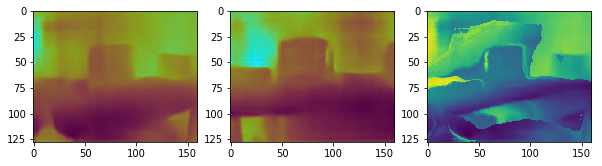

In [41]:
plt.rcParams['figure.figsize'] = [10, 10]

plt.figure(1)
plt.subplot(131)
plt.imshow(img1)

plt.subplot(132)
plt.imshow(img2)

plt.subplot(133)
plt.imshow(ttt1)

In [68]:
grad = conv(img10[:,:,0])

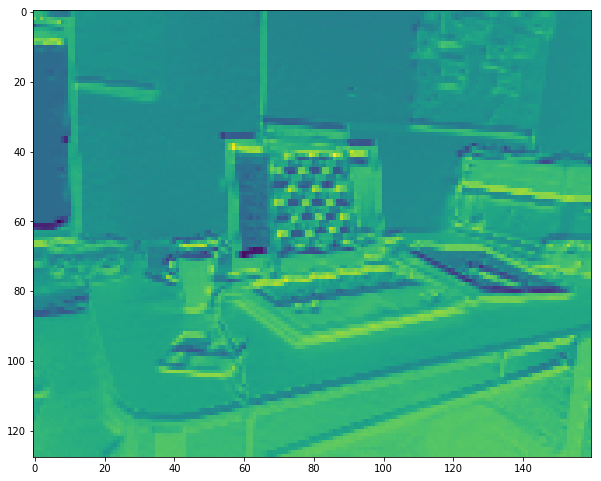

In [69]:
plt.imshow(grad)

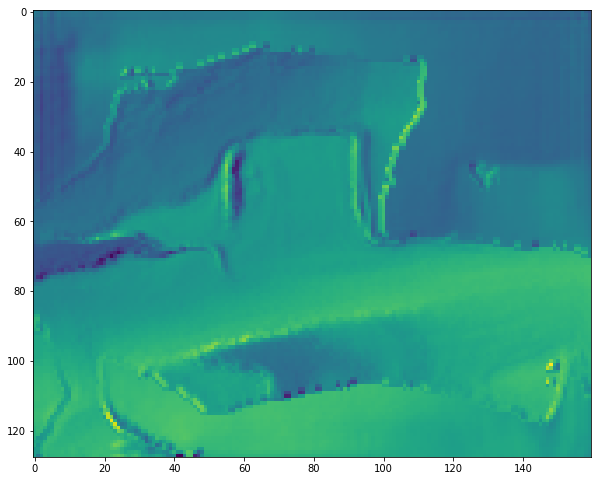

In [64]:
plt.imshow(grad)

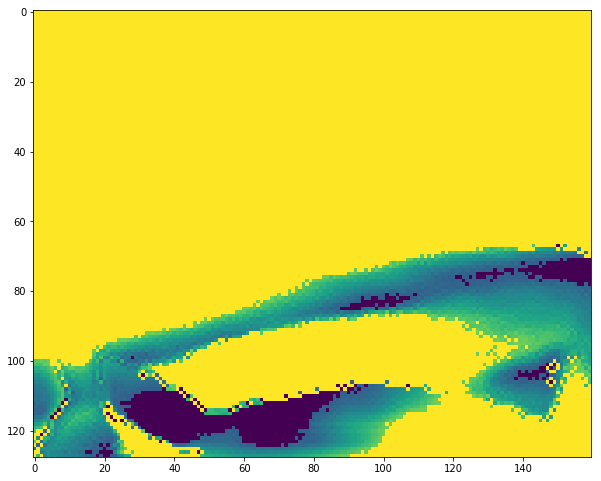

In [60]:
imgt = grad
imgt[imgt>200] = 255
imgt[imgt<75] = 0

plt.imshow(imgt)


In [65]:
def conv(ttt1):
    scharr = np.array([[ 1, 0,  -1 ],
                   [2, 0, -2 ],
                   [ -1, 0,  -1]]) 
    grad = signal.convolve2d(ttt1, scharr.T, boundary='symm', mode='same')
    return grad

In [416]:
img10 = cv2.imread('cv/c1.jpg')
img10 = cv2.resize(img10, (160, 128))
img20 = cv2.imread('cv/c2.jpg')
img20 = cv2.resize(img20, (160, 128))


T_eye = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
res1 = vert(img20, grad, T_eye, mtx,inv = False)
res2 = vert(img10, img1[:,:,1], T_eye, mtx,inv = False)

In [ ]:

write_ply('out2.ply', res1)
print('%s saved' % 'out1.ply')

In [10]:
t = np.arange(10)
np.concatenate((t,t))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

AA

In [14]:
u.shape

(90,)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri
from scipy.spatial import Delaunay

# u, v are parameterisation variables
t = np.arange(10)

u = np.concatenate((t,t,t,t,t,t,t,t,t,t))
v = u

x = u
y = v
z = np.zeros(100)

depth = img1[:,:,1]

for i in range(len(z)):
    z[i] = depth[x[i]+50,y[i]+50]


# Triangulate parameter space to determine the triangles
#tri = mtri.Triangulation(u, v)
tri = Delaunay(np.array([u,v]).T)

print ('polyhedron(faces = [')
#for vert in tri.triangles:
for vert in tri.simplices:
    print ('[%d,%d,%d],' % (vert[0],vert[1],vert[2]))
print ('], points = [')
for i in range(x.shape[0]):
    print ('[%f,%f,%f],' % (x[i], y[i], z[i]))
print (']);')


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_trisurf(x, y, z, triangles=tri.simplices, cmap=plt.cm.Spectral)


plt.show()

QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull d Q12 Qt Qc Qbb Qz
Options selected for Qhull 2015.2.r 2016/01/18:
  run-id 346870385  delaunay  Q12-no-wide-dup  Qtriangulate  Qcoplanar-keep
  Qbbound-last  Qz-infinity-point  _pre-merge  _zero-centrum  Qinterior-keep
  Pgood  _max-width  9  Error-roundoff 1.2e-14  _one-merge 8.7e-14
  Visible-distance 2.5e-14  U-coplanar-distance 2.5e-14  Width-outside 5e-14
  _wide-facet 1.5e-13

precision problems (corrected unless 'Q0' or an error)
      2 flipped facets

The input to qhull appears to be less than 3 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p5(v3):     5     5   2.5
- p100(v2):   4.5   4.5     9
- p9(v1):     9     9   8.2
- p0(v0):     0     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.2e-14.  The center point, facets and distances
to the center point are as follows:

center point    4.625    4.625    4.927

facet p100 p9 p0 distance=    0
facet p5 p9 p0 distance=    0
facet p5 p100 p0 distance=    0
facet p5 p100 p9 distance=    0

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:         0         9  difference=    9
  1:         0         9  difference=    9
  2:         0         9  difference=    9

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 1.2e-14.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.
